<a href="https://colab.research.google.com/github/hariravikumar/Generative-AI/blob/main/huggingface/Classification/food_notfood_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this project, we’re going to focus on fine-tuning the BERT model.



#### Workflow we're going to follow

Our motto is *data, model, demo!*

So we're going to follow the rough workflow of:

1. Create and preprocess data.
2. Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

I say rough because machine learning projects are often non-linear in nature.

As in, because machine learning projects involve many experiments, they can kind of be all over the place.

But this worfklow will give us some good guidelines to follow.

<figure style="text-align: center; display: inline-block;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/01-hugging-face-workflow.png"
     alt="The diagram shows the Hugging Face model development workflow, which includes the following steps: start with an idea or problem, get data ready (turn into tensors/create data splits), pick a pretrained model (to suit your problem), train/fine-tune the model on your custom data, evaluate the model, improve through experimentation, save and upload the fine-tuned model to the Hugging Face Hub, and turn your model into a shareable demo. Tools used in this workflow are Datasets/Tokenizers, Transformers/PEFT/Accelerate/timm, Hub/Spaces/Gradio, and Evaluate."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption style="width: 100%; box-sizing: border-box;">A general Hugging Face workflow from idea to shared model and demo using tools from the Hugging Face ecosystem. You'll notice some of the steps don't match with our workflow outline above. This is because the text-based workflow outline above breaks some of the steps down for educational purposes. These kind of workflows are not set in stone and are more of guide than specific directions. See information on each of the tools in the <a href="https://huggingface.co">Hugging Face documentation</a>.</figcaption>
</figure>

## Importing necessary libraries

Let's get started!

First, we'll import the required libraries.

If you're running on your local computer, be sure to check out the getting [setup guide](https://www.learnhuggingface.com/extras/setup) to make sure you have everything you need.

If you're using Google Colab, many of them the following libraries will be installed by default.

However, we'll have to install a few extras to get everything working.

::: {.callout-note}

If you're running on Google Colab, this notebook will work best with access to a GPU. To enable a GPU, go to `Runtime` ➡️ `Change runtime type` ➡️ `Hardware accelerator` ➡️ `GPU`.

:::

We'll need to install the following libraries from the Hugging Face ecosystem:

* [`transformers`](https://huggingface.co/docs/transformers/en/installation) - comes pre-installed on Google Colab but if you're running on your local machine, you can install it via `pip install transformers`.
* [`datasets`](https://huggingface.co/docs/datasets/installation) - a library for accessing and manipulating datasets on and off the Hugging Face Hub, you can install it via `pip install datasets`.
* [`evaluate`](https://huggingface.co/docs/evaluate/installation) - a library for evaluating machine learning model performance with various metrics, you can install it via `pip install evaluate`.
* [`accelerate`](https://huggingface.co/docs/accelerate/basic_tutorials/install) - a library for training machine learning models faster, you can install it via `pip install accelerate`.
* [`gradio`](https://www.gradio.app/guides/quickstart#installation) - a library for creating interactive demos of machine learning models, you can install it via `pip install gradio`.

We can also check the versions of our software with `package_name.__version__`.

In [2]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.53.0
Using datasets version: 3.6.0
Using torch version: 2.6.0+cu124


In [ ]:
print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.51.3
Using datasets version: 3.6.0
Using torch version: 2.6.0+cu124


## Getting a dataset

Okay, now we're got the required libraries, let's get a dataset.

Getting a dataset is one of the most important things a machine learning project.

The dataset you often determines the type of model you use as well as the quality of the outputs of that model.

Meaning, if you have a high quality dataset, chances are, your future model could also have high quality outputs.

It also means if your dataset is of poor quality, your model will likely also have poor quality outputs.

For a text classificaiton problem, your dataset will likely come in the form of text (e.g. a paragraph, sentence or phrase) and a label (e.g. what category the text belongs to).


<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/harikrishna-ravikumar/food_notfood/embed/viewer/default/train"
     alt="A screenshot of a webpage from Hugging Face's datasets section, specifically showing the 'learn_hf_food_not_food_image_captions' dataset by user mrdourke. The page displays a dataset card with a dataset viewer for a text classification task. The viewer shows examples of captions with their corresponding labels, distinguishing between 'food' and 'not_food.' The screenshot includes interface elements like navigation menus, a search bar, and options to use or edit the dataset."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Our <a href="https://huggingface.co/datasets/harikrishna-ravikumar/food_notfood"> food not food image caption dataset</a> on the Hugging Face Hub.</figcaption>
</figure>

In our case, our dataset comes in the form of a collection of synthetic image captions and their corresponding labels (food or not food).

This is a dataset I've created earlier to help us practice building a text classification model.

You can find it on Hugging Face under the name [`harikrishna-ravikumar/learn_hf_food_not_food_image_captions`](https://huggingface.co/datasets/harikrishna-ravikumar/food_notfood).

::: {.callout-tip}

## Food Not Food Image Caption Dataset Creation

You can see how the Food Not Food image caption dataset was created in the example [Google Colab notebook](https://colab.research.google.com/drive/14xr3KN_HINY5LjV0s2E-4i7v0o_XI3U8?usp=sharing).

A Large Language Model (LLM) was asked to generate various image caption texts about food and not food.

Getting another model to create data for a problem is known as **synthetic data generation** and is a very good way of bootstrapping towards creating a model.

One workflow would be to use real data wherever possible and use synthetic data to boost when needed.

Note that it's always advised to evaluate/test models on real-life data as opposed to synthetic data.
   
:::

## Loading the dataset

Once we've found/prepared a dataset on the Hugging Face Hub, we can use the Hugging Face [`datasets`](https://huggingface.co/docs/datasets/en/index) library to load it.

To load a dataset we can use the [`datasets.load_dataset(path=NAME_OR_PATH_OF_DATASET)`](https://huggingface.co/docs/datasets/en/package_reference/loading_methods#datasets.load_dataset) function and pass it the name/path of the dataset we want to load.

In our case, our dataset name is `harikrishna-ravikumar/food_notfood` (you can also change this for your own dataset).

And since our dataset is hosted on Hugging Face, when we run the following code for the first time, it will download it.

If your target dataset is quite large, this download may take a while.

However, once the dataset is downloaded, subsequent reloads will be mush faster.

In [ ]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="harikrishna-ravikumar/food_notfood")

# Inspect the dataset
dataset

README.md:   0%|          | 0.00/345 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.58M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Text', 'Label'],
        num_rows: 500000
    })
})

#### Rename features  to  lowercase

In [ ]:
dataset = dataset.rename_column("Text", "text")
dataset = dataset.rename_column("Label", "label")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 500000
    })
})

Dataset loaded!

The dataset has two features, `Text` and `Label`.

And 250 total rows (the number of examples in our dataset).

We can check the column names with `dataset.column_names`.

In [ ]:
# What features are there?
dataset.column_names

{'train': ['text', 'label']}

Looks like our dataset comes with a `train` split already (the whole dataset).

We can access the `train` split with `dataset["train"]` (some datasets also come with built-in `"test"` splits too).

In [ ]:
# Access the training split
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 500000
})

In [ ]:
#How about we check out a single sample?
#We can do so with indexing.

dataset["train"][0]

{'text': 'The Cookies was delicious at the restaurant.', 'label': 'food'}

Nice! We get back a dictionary with the keys `text` and `label`.

The `Txt` key contains the text of the image caption and the `Label` key contains the label (food or not food).

### Inspect random examples from the dataset

In [ ]:
import random

random_indexs = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexs]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Just bought a new Notebook online. | Label: not_food
Text: He served me a plate of Watermelon. | Label: food
Text: My Headphones broke yesterday. | Label: not_food
Text: Bought fresh Ham from the market. | Label: food
Text: Craving some Oatmeal right now. | Label: food


Beautiful! Looks like our data contains a mix of shorter and longer sentences (between 5 and 20 words) of texts about food and not food.

We can get the unique labels in our `dataset with [`dataset["train"].unique`("label")`](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.unique).

In [ ]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [ ]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 249281, 'not_food': 250719})

Excellent, looks like our dataset is well balanced with 25k samples of food and 25k samples of not food.

In a binary classification case, this is ideal.

If the classes were dramatically unbalanced (e.g. 90% food and 10% not food) we might have to consider collecting/creating more data.

But best to train a model and see how it goes before making any drastic dataset changes.

Because our dataset is small, we could also inspect it via a pandas DataFrame (however, this may not be possible for extremely large datasets).

In [ ]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
423085,We made homemade Salad yesterday.,food
350884,Charging my Wall clock overnight.,not_food
88197,Is there any Crackers left in the fridge?,food
394060,Is there any Grilled salmon left in the fridge?,food
13165,Favorite snack: Smoothie.,food
77300,Need to clean the Backpack this weekend.,not_food
80098,The Tofu stir fry was delicious at the restaur...,food


In [ ]:
# Get the value counts of the label column
food_not_food_df["label"].value_counts()

,count
label,
not_food,250719
food,249281


## Preparing data for text classification

We've got our data ready but there are a few steps we'll need to take before we can model it.

The main two being:

1. **Tokenization** - turning our text into a numerical representation (machines prefer numbers rather than words), for example, `{"a": 0, "b": 1, "c": 2...}`.
2. **Creating a train/test split** - right now our data is in a training split only but we'll create a test set to evaluate our model's performance.

These don't necessarily have to be in order either.

Before we get to them, let's create a small mapping from our labels to numbers.

In the same way we need to tokenize our text into numerical representation, we also need to do the same for our labels.

### Creating a mapping from labels to numbers

Our machine learning model will want to see all numbers (people do well with text, computers do well with numbers).

This goes for text as well as label input.

So let's create a mapping from our labels to numbers.

Since we've only got a couple of labels (`"food"` and `"not_food"`), we can create a dictionary to map them to numbers, however, if you've got a fair few labels, you may want to make this mapping programmatically.

We can use these dictionaries later on for our model training as well as evaluation.

In [ ]:
# Create mapping from id2label and label2id
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


::: {.callout-note}

In a binary classification task (such as what we're working on), the positive class, in our case `"food"`, is usually given the label `1` and the negative class (`"not_food"`) is given the label `0`.

:::

Rather than hard-coding our label to ID maps, we can also create them programmatically from the dataset (this is helpful if you have many classes).

In [ ]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])} # reverse sort list to have "not_food" first
label2id = {label: idx for idx, label in id2label.items()}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


With our dictionary mappings created, we can update the labels of our dataset to be numeric.

We can do this using the [`datasets.Dataset.map`](https://huggingface.co/docs/datasets/en/process#map) method and passing it a function to apply to each example.

Let's create a small function which turns an example label into a number.

In [ ]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

In [ ]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

{'text': ['The Cookies was delicious at the restaurant.',
  'My Toothbrush broke yesterday.',
  'My Coffee table broke yesterday.',
  'The Router was delivered today.',
  'Just fixed the Remote in the garage.'],
 'label': [1, 0, 0, 0, 0]}

Looks like our labels are all numerical now.

We can check a few random samples using [`dataset.shuffle()`](https://huggingface.co/docs/datasets/en/process#shuffle) and indexing for the first few.

In [ ]:
# Shuffle the dataset and view the first 5 samples (will return different results each time)
dataset.shuffle()[:5]

{'text': ['Is there any Crackers left in the fridge?',
  'Craving some Carrot sticks right now.',
  'Just fixed the Car keys in the garage.',
  'He served me a plate of Oatmeal.',
  'He served me a plate of Chicken curry.'],
 'label': [1, 1, 0, 1, 1]}

### Split the dataset into training and test sets

Right now our dataset only has a training split.

However, we'd like to create a test split so we can evaluate our model.

In essence, our model will learn patterns (the relationship between text captions and their labels of food/not_food) on the training data.

And we will evaluate those learned patterns on the test data.

We can split our data using the [`datasets.Dataset.train_test_split`](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) method.

We can use the `test_size` parameter to define the percentage of data we'd like to use in our test set (e.g. `test_size=0.2` would mean 20% of the data goes to the test set).

In [ ]:
# Create train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42) # note: seed isn't needed, just here for reproducibility, without it you will get different splits each time you run the cell
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 400000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100000
    })
})

In [ ]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]

random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: Trying a new recipe for Green tea tonight.
Label: 1 (food)

[INFO] Random sample from testing dataset:
Text: Just fixed the Router in the garage.
Label: 0 (not_food)


### Tokenizing text data

Labels numericalized, dataset split, time to turn our text into numbers.

How?

**Tokenization**.

What's tokenization?

Tokenization is the process of converting a non-numerical data source into numbers.

Why?

Because machines (especially machine learning models) prefer numbers to human-style data.

In the case of the text `"I love pizza"` a very simple method of tokenization might be to convert each word to a number.

For example, `{"I": 0, "love": 1, "pizza": 2}`.

However, for most modern machine learning models, the tokenization process is a bit more nuanced.

For example, the text `"I love pizza"` might be tokenized into something more like `[101, 1045, 2293, 10733, 102]`.

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/05-example-of-tokenization-with-openai-tokenizer.png"
     alt="Comparison showing tokenization of the text 'I love learning about machine learning and building my own models' using the OpenAI Tokenizer. The left image displays the text segmented into tokens with colors indicating different words, illustrating 'People like words.' The right image shows the same text converted into numerical token IDs, demonstrating 'Machines prefer numbers.' The text is split into 11 tokens, translating to numerical values that the machine can process, highlighting how natural language is transformed for machine understanding."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Although it may seem like you can type text directly to machine learning models, behind the scenes they are converting it to numbers first. This happens for all kinds of data being passed to machine learning models. It goes from its raw form (e.g. text, image, audio) and gets turned into a numerical representation (often called tokenization) before it is processed by the model. Exactly how data gets turned into numbers will often be different depending on the model. This example shows the use of <a href="https://platform.openai.com/tokenizer">OpenAI's GPT-3.5 & GPT-4 tokenizer</a>.</figcaption>
</figure>

    

  ::: {callout-note}
  Depending on the model you use, the tokenization process could be different.

  For example, one model might turn `"I love pizza"` into `[40, 3021, 23317]`, where as another model might turn it into `[101, 1045, 2293, 10733, 102]`.

  To deal with this, Hugging Face models often pair models and tokenizers together by name.

  Such is the case with [`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased) (there is a `tokenizer.json` file as well as a `tokenizer_config.json` file which contains all of the tokenizer implementation details).

  For more examples of tokenization, you can see OpenAI's [tokenization visualizer tool](https://platform.openai.com/tokenizer) as well as their open-source library [`tiktoken`](https://github.com/openai/tiktoken), Google also have an open-source tokenization library called [`sentencepiece`](https://github.com/google/sentencepiece), finally Hugging Face's [`tokenizers`](https://github.com/huggingface/tokenizers) library is also a great resource (this is what we'll be using behind the scenes).
  :::

Many of the text-based models on Hugging Face come paired with their own tokenizer.

For example, the [`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased) model is paired with the `distilbert/distilbert-base-uncased` tokenizer.

We can load the tokenizer for a given model using the [`transformers.AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes) method and passing it the name of the model we'd like to use.

The `transformers.AutoTokenizer` class is part of a series of Auto Classes (such as `AutoConfig`, `AutoModel`, `AutoProcessor`) which automatically loads the correct configuration settings for a given model ID.

Let's load the tokenizer for the `distilbert/distilbert-base-uncased` model and see how it works.

:::{.callout-note}

Why use the `distilbert/distilbert-base-uncased` model?

The short answer is that I've used it before and it works well (and fast) on various text classification tasks.

It also performed well in the [original research paper](https://arxiv.org/abs/1910.01108) which introduced it.

The longer answer is that Hugging Face has many available open-source models for many different problems available at [https://huggingface.co/models](https://huggingface.co/models).

Navigating these models can take some practice.

And several models may be suited for the same task (though with various tradeoffs such as size and speed).

However, overtime and with adequate experimentation, you'll start to build an intuition on which models are good for which problems.

:::

    ::: {.callout-note title="Example"}
    This is the content of a callout.
    :::
   

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

There's our tokenizer!

It's an instance of the [`transformers.DistilBertTokenizerFast`](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/distilbert#transformers.DistilBertTokenizerFast) class.

You can read more about it in the documentation.

For now, let's try it out by passing it a string of text.

In [ ]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
# Try adding a "!" at the end
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

Our text gets turned into numbers (or tokens).

Notice how with even a slight change in the text, the tokenizer produces different results?

The `input_ids` are our tokens.

And the `attention_mask` (in our case, all `[1, 1, 1, 1, 1, 1]`) is a mask which tells the model which tokens to use or not.

Tokens with a mask value of `1` get used and tokens with a mask value of `0` get ignored.

There are several attributes of the `tokenizer` we can explore.

* `tokenizer.vocab` will return the vocabulary of the tokenizer or in other words, the unique words/word pieces the tokenizer is capable of converting into numbers.
* `tokenizer.model_max_length` will return the maximum length of a sequence the tokenizer can process, pass anything longer than this and the sequence will be truncated.

In [ ]:
# Get the length of the vocabulary
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


Our tokenizer has a vocabulary of `30,522` different words and word pieces.

And it can handle a sequence length of up to `512` (any sequence longer than this will be automatically truncated from the end).

Let's check out some of the vocab.

Can I find my own name?

In [ ]:
# Does "hari" occur in the vocab?
tokenizer.vocab["hari"]

21291

MY name is `21291` in the tokenizer's vocab.

How about "pizza"?

In [ ]:
tokenizer.vocab["pizza"]

10733

What if a word doesn't exist in the vocab?

In [ ]:
tokenizer.vocab["akshita"]

KeyError: 'akshita'

Not to worry, this is okay, since when calling the `tokenizer` on the word, it will automatically split the word into word pieces or subwords.

In [ ]:
tokenizer("akshita")

{'input_ids': [101, 17712, 6182, 2696, 102], 'attention_mask': [1, 1, 1, 1, 1]}

It works!

We can check what word pieces `"akshita"` got broken into with [`tokenizer.convert_ids_to_tokens(input_ids)`](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.convert_ids_to_tokens).

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer("akshita").input_ids)

['[CLS]', 'ak', '##shi', '##ta', '[SEP]']

Ahhh, it seems `"akshita"` was split into thre tokens, `["ak", "##shi", "##ta"]`.

The `"##"` at the start of `"##shi"` means that the sequence is part of a larger sequence.

And the `"[CLS]"` and `"[SEP]"` tokens are special tokens indicating the start and end of a sequence.

Now, since tokenizers can deal with any text, what if there was an unknown token?

For example, rather than `"pizza"` someone used the pizza emoji 🍕?

Let's try!

In [ ]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("🍕").input_ids)

['[CLS]', '[UNK]', '[SEP]']

Ahh, we get the special `"[UNK]"` token.

This stands for "unknown".

The combination of word pieces and `"[UNK]"` special token means that our `tokenizer` will be able to turn almost any text into numbers for our model.

::: {.callout-note}

Keep in mind that just because one tokenizer uses an unknown special token for a particular word or emoji (🍕) doesn't mean another will.

:::

Since the `tokenizer.vocab` is a Python dictionary, we can get a sample of the vocabulary using `tokenizer.vocab.items()`.

How about we get the first 5?

In [ ]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

There's our `'!'` from before! Looks like the first five items are all related to punctuation points.

How about a random sample of tokens?

In [ ]:
import random

random.sample(sorted(tokenizer.vocab.items()), k=5)

[('villas', 27317),
 ('atrocities', 23482),
 ('clutches', 29497),
 ('conjunction', 9595),
 ('rained', 28270)]

### Making a preprocessing function to tokenize text

Rather than tokenizing our texts one by one, it's best practice to define a preprocessing function which does it for us.

This process works regardless of whether you're working with text data or other kinds of data such as images or audio.

::: {.callout-tip}
## Turning data into numbers

For any kind of machine learning workflow, an important first step is turning your input data into numbers.

As machine learning models are algorithms which find patterns in numbers, before they can find patterns in your data (text, images, audio, tables) it must be numerically encoded first (e.g. tokenizing text).

To help with this, `transformers` has an [`AutoProcessor`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoProcessor) class which can preprocess data in a specific format required for a paired model.

:::

To prepare our text data, let's create a preprocessing function to take in a dictionary which contains the key `"text"` which has the value of a target string (our data samples come in the form of dictionaries) and then returns the tokenized `"text"`.

We'll set the following parameters in our `tokenizer`:

* `padding=True` - This will make all the sequences in a batch the same length by padding shorter sequences with 0's until they equal the longest size in the batch. Why? If there are different size sequences in a batch, you can sometimes run into dimensionality issues.
* `truncation=True` - This will shorten sequences longer than the model can handle to the model's max input size (e.g. if a sequence is 1000 long and the model can handle 512, it will be shortened to 512 via removing all tokens after 512).

You can see more parameters available for the `tokenizer` in the [`transformers.PreTrainedTokenizer` documentation](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizer).

::: {.callout-note}

For more on padding and truncation (two important concepts in sequence processing), I'd recommend reading the Hugging Face documentation on [Padding and Truncation](https://huggingface.co/docs/transformers/en/pad_truncation).

:::

In [ ]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [ ]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

How about we map our `tokenize_text` function to our whole `dataset`?

We can do so with the [`datasets.Dataset.map` method](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.map).

The `map` method allows us to apply a given function to all examples in a dataset.

By setting `batched=True` we can apply the given function to batches of examples (many at a time) to speed up computation time.

Let's create a `tokenized_dataset` object by calling `map` on our `dataset` and passing it our `tokenize_text` function.

Now let's try it out on an example sample.

In [ ]:
# Map our tokenize_text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=2000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 400000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 100000
    })
})

Dataset tokenized!

Let's inspect a pair of samples.

In [ ]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: The Drill is on my desk.
Test sample: Bought fresh BBQ ribs from the market.

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 1996, 12913, 2003, 2006, 2026, 4624, 1012, 102, 0, 0, 0, 0, 0]
Test sample: [101, 4149, 4840, 22861, 4160, 10335, 2013, 1996, 3006, 1012, 102, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]



Our samples have been tokenized.

Notice the zeroes on the end of the `inpud_ids` and `attention_mask` values.

These are padding tokens to ensure that each sample has the same length as the longest sequence in a given batch.

We can now use these tokenized samples later on in our model.

### Tokenization takeaways

We've now seen and used tokenizers in practice.

A few takeaways before we start to build a model:

* Tokenizers are used to turn text (or other forms of data such as images and audio) into a numerical representation ready to be used with a machine learning model.
* Many models reuse existing tokenizers and many models have their own specific tokenizer paired with them. Hugging Face's `transformers.AutoTokenizer`, `transformers.AutoProcessor` and `transformers.AutoModel` classes make it easy to pair tokenizers and models based on their name (e.g. `distilbert/distilbert-base-uncased`).

## Setting up an evaluation metric

Aside from training a model, one of the most important steps in machine learning is evaluating a model.

To do, we can use evaluation metrics.

An evaluation metric attempts to represent a model's performance in a single (or series) of numbers (note, I say "attempts" here because evaluation metrics are useful to guage performance but the real test of a machine learning model is in the real world).

There are many different kinds of evaluation metrics for various problems.

But since we're focused on text classification, we'll use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) as our evaluation metric.

A model which gets 99/100 predictions correct has an accuracy of 99%.

$$
\text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}}
$$

For some projects, you may have a minimum standard of a metric.

For example, when I worked on an insurance claim classification model, the clients required over 98% accuracy on the test dataset for it to be viable to use in production.

If needed, we can craft these evaluation metrics ourselves.

However, Hugging Face has a library called [`evaluate`](https://huggingface.co/docs/evaluate/en/index) which has various metrics built in ready to use.

We can load a metric using `evaluate.load("METRIC_NAME")`.

Let's load in `"accuracy"` and build a function to measure accuracy by comparing arrays of predictions and labels.

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

Accuracy function created!

Now let's test it out.

In [ ]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


Excellent, our function works just as we'd like.

When all predictions are correct, it scores 1.0 (or 100% accuracy) and when 9/10 predictions are correct, it returns 0.9 (or 90% accuracy).

We can use this function during training and evaluation of our model.

## Setting up a model for training

We've gone through the important steps of setting data up for training (and evaluation).

Now let's prepare a model.

We'll keep going through the following steps:

1. ✅ Create and preprocess data.
2. Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

Let's start by creating an instance of a model.

Since we're working on text classification, we'll do so with `transformers.AutoModelForSequenceClassification` (where sequence classification means a sequence of something, e.g. our sequences of text).

We can use the `from_pretrained()` method to instatiate a pretrained model from the Hugging Face Hub.

:::{.callout-note}

The "pretrained" in [`transformers.AutoModelForSequenceClassification.from_pretrained`](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/auto#transformers.AutoConfig.from_pretrained) means acquiring a model which has already been trained on a certain dataset.

This is common practice in many machine learning projects and is known as **transfer learning**.

The idea is to take an existing model which works well on a task similar to your target task and then **fine-tune** it to work even better on your target task.

In our case, we're going to use the pretrained DistilBERT base model ([`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased)) which has been trained on [many thousands of books](https://huggingface.co/datasets/bookcorpus/bookcorpus) as well as a version of the [English Wikipedia](https://huggingface.co/datasets/legacy-datasets/wikipedia) (millions of words).

This training gives it a very good baseline representation of the patterns in language.

We'll take this baseline representation of the patterns in language and adjust it slightly to focus specifically on predicting whether an image caption is about food or not (based on the words it contains).

The main two benefits of using transfer learning are:

1. Ability to get good results with smaller amounts of data (since the main representations are learned on a larger dataset, we only have to show the model a few examples of our specific problem).
2. This process can be repeated acorss various domains and tasks. For example, you can take a computer vision model trained on millions of images and customize it to your own use case. Or an audio model trained on many different nature sounds and customize it specifically for birds.

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/09-transfer-learning-example.png"
     alt="Diagram illustrating the concept of transfer learning in two domains: Computer Vision and Natural Language Processing (NLP). In the Computer Vision example, the model is pre-trained on the ImageNet dataset. The model learns patterns and weights from this dataset and is then applied to specific tasks such as identifying images of steak, sushi, and pizza. In the NLP example, the model is pre-trained on large text corpora, such as Wikipedia articles about transfer learning. The learned patterns and weights are then applied to specific tasks, such as classifying text about 'A yellow tractor driving over a grassy hill' as 'Not Food' and 'A photo of sushi rolls on a white plate' as 'Food'. The model learns from a similar problem space and applies the learned patterns to specific problems, improving accuracy and performance."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Transfer learning is the process of taking what one model has learned from a (typically large) dataset and applying them to your own custom dataset. This process can be replicated across domains such as computer vision, natural language processing and more.</figcaption>
</figure>

So when starting a new machine learning project, one of the first questions you should ask is: does an existing pretrained model similar to my task exist and can I fine-tune it for my own task?

For an end-to-end example of transfer learning in PyTorch (another popular deep learning framework), see [PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/).

:::

Time to setup our `model` instance.

A few things to note:

* We'll use [`transformers.AutoModelForSequenceClassification.from_pretrained`](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/auto#transformers.AutoConfig.from_pretrained), this will create the model architecture we specify with the `pretrained_model_name_or_path` parameter.
* The `AutoModelForSequenceClassification` class comes with a classification head on top of our mdoel (so we can customize this to the number of classes we have with the `num_labels` parameter).
* Using `from_pretrained` will also call the [`transformers.PretrainedConfig`](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/configuration#transformers.PretrainedConfig) class which will enable us to set `id2label` and `label2id` parameters for our fine-tuning task.



In [ ]:
# Get id and label mappings
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


 we can pass these mappings to `transformers.AutoModelForSequenceClassification.from_pretrained`.

In [ ]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model created!

You'll notice that a warning message gets displayed:

> Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
> You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

This is essentially saying "hey, some of the layers in this model are newly initialized (with random patterns) and you should probably customize them to your own dataset".

This happens because we used the `AutoModelForSequenceClassification` class.

Whilst the majority of the layers in our model have already learned patterns from a large corpus of text, the top layers (classifier layers) have been randomly setup so we can customize them on our own.

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/07-learning-and-transfer-learning-paradigms.png"
     alt="The diagram illustrates learning and transfer learning paradigms, showing three stages: Pretraining, Feature Extraction, and Full Fine-tuning. In the Pretraining stage, a base model is trained on a large dataset, requiring most compute resources. In the Feature Extraction stage, the base model's parameters are frozen (indicated by a snowflake), and a custom dataset is used to produce custom outputs. In the Full Fine-tuning stage, trainable layers (indicated by flames) are added to the base model using a custom dataset to create customized outputs for specific tasks. The key indicates that flames represent trainable components and snowflakes represent frozen components. This method involves adding layers to a base model to customize it for specific tasks."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Various forms of training paradigms. Typically you'll start with a model that has been pretrained on a large dataset. For example, a base model could be one that has read all of Wikipedia + 1000's of books (like our DistilBert model) and has a good general representation of language data. This representation can then be tailored to a specific use case by customizing the outputs and adjusting the representation slightly by feeding it custom data. This process is often referred to as fine-tuning.</figcaption>
</figure>

Let's try and make a prediction with our model and see what happens.

In [ ]:
# Try and make a prediction with the loaded model (this will error)
#model(**tokenized_dataset["train"][0])

TypeError: DistilBertForSequenceClassification.forward() got an unexpected keyword argument 'text'

Oh no! We get an error.

Not to worry, this is only because our model hasn't been trained on our own dataset yet.

Let's take a look at the layers in our model.

In [ ]:
# Inspect the model
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


You'll notice that the model comes in 3 main parts (data flows through these sequentially):

1. `embeddings` - This part of the model turns the input tokens into a learned representation. So rather than just a list of integers, the values become a learned representation. This learned representation comes from the base model learning how different words and word pieces relate to eachother thanks to its training data. The size of `(30522, 768)` means the `30,522` words in the vocabulary are all represented by vectors of size `768` (one word gets represented by 768 numbers, these are often not human interpretable).
2. `transformer` - This is the main body of the model. There are several `TransformerBlock` layers stacked on top of each other. These layers attempt to learn a deeper representation of the data going through the model. A thorough breakdown of these layers is beyond the scope of this tutorial, however, for and in-depth guide on Transformer-based models, I'd recommend reading [*Transformers from scratch*](https://peterbloem.nl/blog/transformers) by Peter Bloem, going through [Andrej Karpathy's lecture on Transformers and their history](https://www.youtube.com/watch?v=XfpMkf4rD6E) or reading the original [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper (this is the paper that introduced the Transformer architecture).
3. `classifier` - This is what is going to take the representation of the data and compress it into our number of target classes (notice `out_features=2`, this means that we'll get two output numbers, one for each of our classes).

For more on the entire DistilBert architecture and its training setup, I'd recommend reading the [*DistilBert paper*](https://arxiv.org/abs/1910.01108) from the Hugging Face team.

Rather than breakdown the model itself, we're focused on using it for a particular task (classifying text).

### Counting the parameters of our model

Before we move into training, we can get another insight into our model by counting its number of parameters.

Let's create a small function to count the number of trainable (these will update during training) and total parameters in our model.

In [ ]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Looks like our model has a total of 66,955,010 parameters and all of them are trainable.

A parameter is a numerical value in a model which is capable of being updated to better represent the input data.

I like to think of them as a small opportunity to learn patterns in the data.

If a model has three parameters, it has three small opportunities to learn patterns in the data.

Whereas, if a model has 60,000,000+ (60M) parameters (like our `model`), it has 60,000,000+ small opportunities to learn patterns in the data.

Some models such as Large Language Models (LLMs) like [Llama 3 70B](https://huggingface.co/meta-llama/Meta-Llama-3-70B) have 70,000,000,000+ (70B) parameters (over 1000x our model).

In essence, the more parameters a model has, the more opportunities it has to learn (generally).

More parameters often results in more capabilities.

However, more parameters also often results in a much larger model size (e.g. many gigabytes versus hundreds of megabytes) as well as a much longer compute time (fewer samples per second).

For our use case, a binary text classification task, 60M parameters is more than enough.

::: {.callout-note}

Why count the parameters in a model?

While it may be tempting to always go with a model that has the most parameters, there are many considerations to take into account before doing so.

> What hardware is the model going to run on?

If you need the model to run on cheap hardware, you'll likely want a smaller model.

> How fast do you need the model to be?

If you need 100-1000s of predictions per second, you'll likely want a smaller model.

> "I don't mind about speed or cost, I just want quality."

Go with the biggest model you can.

However, often times you can get really good results by training a small model to do a specific task using quality data than by just always using a large model.

:::

### Create a directory for saving models

Training a model can take a while.

So we'll want a place to save our models.

Let's create a directory called `"food_not_food_text_classifier-distilbert-base-uncased"` (it's a bit verbose and you can change this if you like but I like to be specific).

In [ ]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/food_not_food_text_classifier-distilbert-base-uncased')

### Setting up training arguments with TrainingArguments

Time to get our model ready for training!

We're up to step 3 of our process:

1. ✅ Create and preprocess data.
2. ✅ Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

The `transformers.TrainingArguments` class contains a series of helpful items, including hyperparameter settings and model saving strategies to use throughout training.

It has many parameters, too many to explain here.

However, the following table breaks down a helpful handful.

Some of the parameters we'll set are the same as the defaults (this is on purpose as the defaults are often pretty good), some such as `learning_rate` are different.

| Parameter | Explanation |
|:-----|:-----|
| `output_dir` | Name of output directory to save the model and checkpoints to. For example, `learn_hf_food_not_food_text_classifier_model`.  |
| `learning_rate` | Value of the initial learning rate to use during training. Passed to [`transformers.AdamW`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments). Initial learning rate because the learning rate can be dynamic during training. The ideal learning is experimental in nature. Defaults to `5e-5` or `0.00001` but we'll use `0.0001`.  |
| `per_device_train_batch_size`| Size of batches to place on target device during training. For example, a batch size of `32` means the model will look at 32 samples at a time. A batch size too large will result in out of memory issues (e.g. your GPU can't handle holding a large number of samples in memory at a time). |
| `per_device_eval_batch_size` | Size of batches to place on target device during evaluation. Can often be larger than during training because no gradients are being calculated. For example, training batch size could be 32 where as evaluation batch size may be able to be 128 (4x larger). Though these are only esitmates. |
| `num_train_epochs` | Number of times to pass over the data to try and learn patterns. For example, if `num_train_epochs=10`, the model will do 10 full passes of the training data. Because we're working with a small dataset, 10 epochs should be fine to begin with. However, if you had a larger dataset, you may want to do a few experiments using less data (e.g. 10% of the data) for a smaller number of epochs to make sure things work. |
| `eval_strategy` | When to evaluate the model on the evaluation data. If `eval_strategy="epoch"`, the model will be evaluated every epoch. See the documentation for more options. **Note:** This was previously called `evaluation_strategy` but was shortened in `transformers==4.46`. |
| `save_strategy` | When to save a model checkpoint. If `save_strategy="epoch"`, a checkpoint will be saved every epoch. See the documentation for more save options. |
| `save_total_limit` | Number of total amount of checkpoints to save (so we don't save `num_train_epochs` checkpoints). For example, can limit to 3 saves so the total number of saves are the 3 most recent as well as the best performing checkpoint (as per `load_best_model_at_end`). |
| `use_cpu` | Set to `False` by default, will use CUDA GPU (`torch.device("cuda")`) or MPS device (`torch.device("mps")`, for Mac) if available. This is because training is generally faster on an accelerator device. |
| `seed` | Set to `42` by default for reproducibility. Meaning that subsequent runs with the same setup should achieve the same results. |
| `load_best_model_at_end` | When set to `True`, makes sure that the best model found during training is loaded when training finishes. This will mean the best model checkpoint gets saved regardless of what epoch it happened on. This is set to `False` by default. |
| `logging_strategy` | When to log the training results and metrics. For example, if `logging_strategy="epoch"`, results will be logged as outputs every epoch. See the documentation for more logging options. |
| `report_to` | Log experiments to various experiment tracking services. For example, you can log to Weights & Biases using `report_to="wandb"`. We'll turn this off for now and keep logging to a local directory by setting `report_to="none"`. |
| `push_to_hub` | Automatically upload the model to the Hugging Face Hub every time the model is saved. We'll set `push_to_hub=False` as we'll see how to do this manually later on. See the documentation for more options on saving models to the Hugging Face Hub. |
| `hub_token` | Add your Hugging Face Hub token to push a model to the Hugging Face Hub with `push_to_hub` (will default to [`huggingface-cli login`](https://huggingface.co/docs/huggingface_hub/en/guides/cli) details). |
| `hub_private_repo` | Whether or not to make the Hugging Face Hub repository private or public, defaults to `False` (e.g. set to `True` if you want the repository to be private). |

::: {.callout-note}

To get more familiar with the `transformers.TrainingArguments` class, I'd highly recommend [reading the documentation](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments) for 15-20 minutes. Perhaps over a couple of sessions. There are quite a large number of parameters which will be helpful to be aware of.

:::



That was a lot to take in.

But let's now practice setting up our own instance of `transformers.TrainingArguments`.

In [ ]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch", # was previously "evaluation_strategy"
    save_strategy="epoch",
    save_total_limit=3, # limit the total amount of save checkpoints (so we don't save num_epochs checkpoints)
    use_cpu=False, # set to False by default, will use CUDA GPU or MPS device if available
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # log training results every epoch
    report_to="none", # optional: log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now)
    # push_to_hub=True # optional: automatically upload the model to the Hub (we'll do this manually later on)
    # hub_token="your_token_here" # optional: add your Hugging Face Hub token to push to the Hub (will default to huggingface-cli login)
    hub_private_repo=False # optional: make the uploaded model private (defaults to False)
)

# Optional: Print out training_args to inspect (warning, it is quite a long output)
# training_args

[INFO] Saving model checkpoints to: models/food_not_food_text_classifier-distilbert-base-uncased


Training arguments created!

Let's put them to work in an instance of `transformers.Trainer`.

Training arguments created!

Let's put them to work in an instance of `transformers.Trainer`.

### Setting up an instance of Trainer

Time for step 4!

1. ✅ Create and preprocess data.
2. ✅ Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. ✅ Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

The [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer) class allows you to train models.

It's built on PyTorch so it gets to leverage all of the powerful PyTorch toolkit.

But since it also works closely with the `transformers.TrainingArguments` class, it offers many helpful features.

::: {.callout-note}

`transformers.Trainer` can work with `torch.nn.Module` models, however, it is designed to work best with [`transformers.PreTrainedModel`](https://huggingface.co/docs/transformers/main/en/main_classes/model#transformers.PreTrainedModel)'s from the `transformers` library.

This is not a problem for us as we're using `transformers.AutoModelForSequenceClassification.from_pretrained` which loads a `transformers.PreTrainedModel`.

See the [`transformers.Trainer` documentation](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer) for tips on how to make sure your model is compatible.

:::

| Parameter | Explanation |
|:-----|:-----|
| `model` | The model we'd like to train. Works best with an instance of `transformers.PreTrainedModel`. Most models loaded using `from_pretrained` will be of this type. |
| `args` | Instance of `transformers.TrainingArguments`. We'll use the `training_args` object we defined earlier. But if this is not set, it will default to the default settings for `transformers.TrainingArguments`. |
| `train_dataset`| Dataset to use during training. We can use our `tokenized_dataset["train"]` as it has already been preprocessed. |
| `eval_dataset` | Dataset to use during evaluation (our model will not see this data during training). We can use our `tokenized_dataset["test"]` as it has already been preprocessed.  |
| `tokenizer` | The `tokenizer` which was used to preprocess the data. Passing a tokenizer will also pad the inputs to maximum length when batching them. It will also be saved with the model so future re-runs are easier. |
| `compute_metrics` | An evaluation function to evaluate a model during training and evaluation steps. In our case, we'll use the `compute_accuracy` function we defined earlier. |

With all this being said, let's build our `Trainer`!

In [ ]:
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    # Note: the 'tokenizer' parameter will be changed to 'processing_class' in Transformers v5.0.0
    tokenizer=tokenizer, # Pass tokenizer to the Trainer for dynamic padding (padding as the training happens) (see "data_collator" in the Trainer docs)
    compute_metrics=compute_accuracy
)

<ipython-input-38-a2fafd012213>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Woohoo! We've created our own `trainer`.

We're one step closer to training!

### Training our text classification model

We've done most of the hard word setting up our `transformers.TrainingArguments` as well as our `transformers.Trainer`.

Now how about we train a model?

Following our steps:

1. ✅ Create and preprocess data.
2. ✅ Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. ✅ Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. ✅ Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

Looks like all we have to do is call `transformers.Trainer.train()`.

We'll be sure to save the results of the training to a variable `results` so we can inspect them later.

Let's try!

In [ ]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,0.000000,1.000000
2,0.000000,0.000000,1.000000
3,0.000000,0.000000,1.000000
4,0.000000,0.000000,1.000000
5,0.000000,0.000000,1.000000
6,0.000000,0.000000,1.000000
7,0.000000,0.000000,1.000000
8,0.000000,0.000000,1.000000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,0.000000,1.000000
2,0.000000,0.000000,1.000000
3,0.000000,0.000000,1.000000
4,0.000000,0.000000,1.000000
5,0.000000,0.000000,1.000000
6,0.000000,0.000000,1.000000
7,0.000000,0.000000,1.000000
8,0.000000,0.000000,1.000000
9,0.000000,0.000000,1.000000
10,0.000000,0.000000,1.000000


How about we check some of the metrics?

We can do so using the `results.metrics` attribute (this returns a Python dictionary with stats from our training run).

In [ ]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 8169.0123
train_samples_per_second: 489.655
train_steps_per_second: 15.302
total_flos: 1.4488621728e+16
train_loss: 2.611564436554721e-05
epoch: 10.0


And looks like our `trainer` was able to process a fair few samples per second.

If we were to 1000x the size of our dataset (e.g. ~250 samples -> ~250,000 samples which is quite a substantial dataset), it seems our training time still wouldn't take too long.

The `total_flos` stands for "[floating point operations](https://en.wikipedia.org/wiki/FLOPS)" (also referred to as FLOPS), this is the total number of calculations our model has performed to find patterns in the data. And as you can see, it's quite a large number!

::: {.callout-note}

Depending on the hardware you're using, the results with respect to `train_runtime`, `train_samples_per_second` and `train_steps_per_second` will likely be different.

The faster your accelerator hardware (e.g. NVIDIA GPU or Mac GPU), the lower your runtime and higher your samples/steps per second will be.

For reference, on my local NVIDIA RTX 4090, I get a `train_runtime` of 8-9 seconds, `train_samples_per_second` of 230-250 and `train_steps_per_second` of 8.565.

:::

### Save the model for later use

Now our model has been trained, let's save it for later use.

We'll save it locally first and push it to the Hugging Face Hub later.

We can save our model using the [`transformers.Trainer.save_model`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.save_model) method.

In [ ]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/food_not_food_text_classifier-distilbert-base-uncased


Model saved locally! Before we save it to the Hugging Face Hub, let's check out its metrics.

### Inspecting the model training metrics

We can get a log of our model's training state using `trainer.state.log_history`.

This will give us a collection of metrics per epoch (as long as we set `logging_strategy="epoch"` in `transformers.TrainingArguments`), in particular, it will give us a loss value per epoch.

We can extract these values and inspect them visually for a better understanding our model training.

Let's get the training history and inspect it.

In [ ]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.0003,
  'grad_norm': 2.900500817304419e-08,
  'learning_rate': 9.000080000000001e-05,
  'epoch': 1.0,
  'step': 12500},
 {'eval_loss': 0.0,
  'eval_accuracy': 1.0,
  'eval_runtime': 46.0384,
  'eval_samples_per_second': 2172.102,
  'eval_steps_per_second': 67.878,
  'epoch': 1.0,
  'step': 12500},
 {'loss': 0.0,
  'grad_norm': 8.247171695563438e-11,
  'learning_rate': 8.000080000000001e-05,
  'epoch': 2.0,
  'step': 25000},
 {'eval_loss': 0.0,
  'eval_accuracy': 1.0,
  'eval_runtime': 45.7105,
  'eval_samples_per_second': 2187.679,
  'eval_steps_per_second': 68.365,
  'epoch': 2.0,
  'step': 25000}]

Okay, looks like the metrics are logged every epochs in a list Python dictionaries with interleaving `loss` (this is the training set loss) and `eval_loss` values.

How about we write some code to separate the training set metrics and the evaluation set metrics?

In [ ]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 2.900500817304419e-08,
  'learning_rate': 9.000080000000001e-05,
  'loss': 0.0003,
  'step': 12500},
 {'epoch': 2.0,
  'grad_norm': 8.247171695563438e-11,
  'learning_rate': 8.000080000000001e-05,
  'loss': 0.0,
  'step': 25000}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.0,
  'eval_runtime': 46.0384,
  'eval_samples_per_second': 2172.102,
  'eval_steps_per_second': 67.878,
  'step': 12500},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.0,
  'eval_runtime': 45.7105,
  'eval_samples_per_second': 2187.679,
  'eval_steps_per_second': 68.365,
  'step': 25000}]


In [ ]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.0003,2.900501e-08,0.00009,1.0,12500
1,0.0000,8.247172e-11,0.00008,2.0,25000
2,0.0000,6.940298e-11,0.00007,3.0,37500
3,0.0000,9.433175e-11,0.00006,4.0,50000
4,0.0000,1.028373e-11,0.00005,5.0,62500


How about we take it a step further and turn our metrics into pandas DataFrames so we can view them easier?

And the evaluation DataFrame?

In [ ]:
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.0,1.0,46.0384,2172.102,67.878,1.0,12500
1,0.0,1.0,45.7105,2187.679,68.365,2.0,25000
2,0.0,1.0,45.6971,2188.322,68.385,3.0,37500
3,0.0,1.0,45.6820,2189.046,68.408,4.0,50000
4,0.0,1.0,45.5980,2193.078,68.534,5.0,62500


And of course, we'll have follow the data explorer's motto of *visualize, visualize, visualize!* and inspect our loss curves.

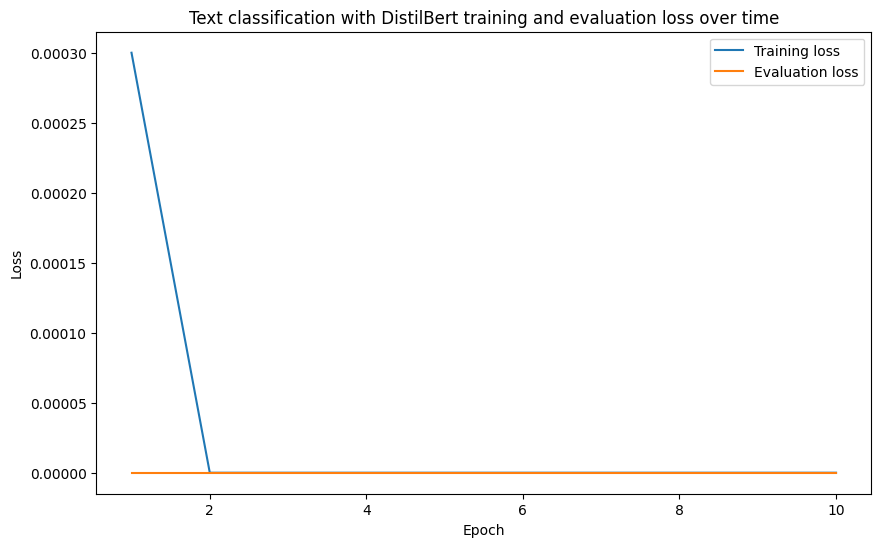

In [ ]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

### Pushing our model to the Hugging Face Hub

We've saved our model locally and confirmed that it seems to be performing well on our training metrics but how about we push it to the Hugging Face Hub?

The Hugging Face Hub is one of the best sources of machine learning models on the internet.

And we can add our model there so others can use it or we can access it in the future (we could also keep it private on the Hugging Face Hub so only people from our organization can use it).

Sharing models on Hugging Face is also a great way to showcase your skills as a machine learning engineer, it gives you something to show potential employers and say "here's what I've done".

:::{.callout-note}

Before sharing a model to the Hugging Face Hub, be sure to go through the following steps:

1. Setup a Hugging Face token using the [`huggingface-cli login` command](https://huggingface.co/docs/huggingface_hub/en/guides/cli).
2. Read through the [user access tokens guide](https://huggingface.co/docs/hub/en/security-tokens).
3. Set up an access token via [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens) (ensure it has "write" access).

If you are using Google Colab, you can add your token under the "Secrets" tab on the left.

On my local computer, my token is saved to `/home/harikrishnaravikumar/.cache/huggingface/token` (thanks to running `huggingface-cli login` on the command line).

And for more on sharing models to the Hugging Face Hub, be sure to check out the [model sharing documentation](https://huggingface.co/docs/transformers/en/model_sharing).

:::

We can push our model, tokenizer and other assosciated files to the Hugging Face Hub using the [`transformers.Trainer.push_to_hub`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

We can also optionally do the following:

* Add a [model card](https://huggingface.co/docs/hub/en/model-cards) (something that describes how the model was created and what it can be used for) using [`transformers.Trainer.create_model_card`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.create_model_card).
* Add a custom `README.md` file to the model repository to explain more details about the model using [`huggingface_hub.HfApi.upload_file`](https://huggingface.co/docs/huggingface_hub/en/guides/upload#upload-a-file). This method is similar to model card creation method above but with more customization.

Let's save our model to the Hub!

In [ ]:
# Save our model to the Hugging Face Hub
# This will be public, since we set hub_private_repo=False in our TrainingArguments
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model",
    # token="YOUR_HF_TOKEN_HERE" # This will default to the token you have saved in your Hugging Face config
)
print(f"[INFO] Model successfully uploaded to Hugging Face Hub with at URL: {model_upload_url}")

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[INFO] Model successfully uploaded to Hugging Face Hub with at URL: https://huggingface.co/harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased/tree/main/


Model pushed to the Hugging Face Hub!

::: {.callout-note}

You may see the following error:

> 403 Forbidden: You don't have the rights to create a model under the namespace "harikrishna-ravikumar".
> Cannot access content at: https://huggingface.co/api/repos/create.
> If you are trying to create or update content, make sure you have a token with the `write` role.

Or even:

> HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6699c52XXXXXX)
>
> Invalid username or password.

In this case, be sure to go through the [setup steps above](https://huggingface.co/docs/hub/en/security-tokens) to make sure you have a Hugging Face access token with "write" access.

:::

And since it's public (by default), you can see it at [harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased](harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased) (it gets saved to the same name as our target local directory).

You can now share and interact with this model online.

As well as download it for use in your own applications.

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/harikrishna-ravikumar/learn-hf-images/resolve/main/learn-hf-text-classification/04-model-on-hf-hub.png"
     alt="
Side-by-side images showcasing the process of using a model from the Hugging Face Hub. The first image shows the model card page for 'learn_hf_food_not_food_text_classifier-distilbert-base-uncased' on Hugging Face Hub, highlighting the 'Use this model' button. The second image displays the code snippet provided by the Hugging Face Transformers library for utilizing the model in a text classification pipeline. This demonstrates the ease of accessing and implementing pretrained models from the Hugging Face Hub using the Transformers library."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>The Hugging Face Hub allows us to store and share models, datasets and demos. We can set these to be private or public. Models stored on the Hub can easily be accessed via Hugging Face Transformers.</figcaption>
</figure>

But before we make an application/demo with our trained model, let's keep evaluating it.

## Making and evaluating predictions on the test data

Model trained, let's now evaluate it on the test data.

Or step 7 in our workflow:

1. ✅ Create and preprocess data.
2. ✅ Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. ✅ Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. ✅ Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. ✅ Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. ✅ Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

A reminder that the test data is data that our model has never seen before.

So it will be a good estimate of how our model will do in a production setting.

We can make predictions on the test dataset using [`transformers.Trainer.predict`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.predict).

And then we can get the prediction values with the `predictions` attribute and assosciated metrics with the `metrics` attribute.

In [ ]:
# Perform predictions on the test set
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0,
 'test_accuracy': 1.0,
 'test_runtime': 50.9993,
 'test_samples_per_second': 1960.811,
 'test_steps_per_second': 61.275}

Looks like our model did an outstanding job!

And it was *very* quick too.

This is one of the benefits of using a smaller pretrained model and customizing it to your own dataset.

You can achieve outstanding results in a very quick time as well as have a model capable of performing thousands of predictions per second.

We can also calculate the accuracy by hand by comparing the prediction labels to the test labels.

To do so, we'll:

1. Calculate the prediction probabilities (though this is optional as we could skip straight to 2 and get the same results) by passing the `prediction_values` to [`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html).
2. Find the index of the prediction value with the highest value (the index will be equivalent to the predicted label) using [`torch.argmax`](https://pytorch.org/docs/stable/generated/torch.argmax.html) (we could also use [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) here) to find the predicted labels.
3. Get the true labels from the test dataset using `dataset["test"]["label"]`.
4. Compare the predicted labels from 2 to the true labels from 3 using [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to find the accuracy.

In [ ]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities (this is optional, could get the same results with step 2 onwards)
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = dataset["test"]["label"]

# 4. Compare predicted labels to true labels to get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")

[INFO] Test accuracy: 100.0%


Looks like our model performs really well on our test set.

It will be interesting to see how it goes on real world samples.

We'll test this later on.

How about we make a pandas DataFrame out of our test samples, predicted labels and predicted probabilities to further inspect our results?

In [ ]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,Bought fresh BBQ ribs from the market.,1,1,1.0
1,Charging my Shoes overnight.,0,0,1.0
2,Need to clean the Shoes this weekend.,0,0,1.0
3,My Headphones broke yesterday.,0,0,1.0
4,Charging my TV stand overnight.,0,0,1.0


We can find the examples with the lowest prediction probability to see where the model is unsure.

In [ ]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
99992,I had Cereal bar for lunch today.,1,1,1.0
99993,My Wallet broke yesterday.,0,0,1.0
99994,Trying a new recipe for Oatmeal tonight.,1,1,1.0
99995,The Keyboard was delivered today.,0,0,1.0
99996,Charging my Refrigerator overnight.,0,0,1.0
99997,He served me a plate of Roasted turkey.,1,1,1.0
99998,Just bought a new Wallet online.,0,0,1.0
99999,The Notebook is on my desk.,0,0,1.0
99984,I had Crackers for lunch today.,1,1,1.0
99985,Charging my Sweater overnight.,0,0,1.0


Hmmm, it looks like our model has quite a high prediction probability for almost all samples.

We can further evalaute our model by making predictions on new custom data.

## Making and inspecting predictions on custom text data

We've seen how our model performs on the test dataset (quite well).

But how might we check its performance on our own custom data?

For example, text-based image captions from the wild.

Well, we've got two ways to load our model now too:

1. Load model locally from our computer (e.g. via `models/food_not_food_text_classifier-distilbert-base-uncased`).
2. Load model from Hugging Face Hub (e.g. via `harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased`).

Either way of loading the model results in the same outcome: being able to make predictions on given data.

So how about we start by setting up our model paths for both local loading and loading from the Hugging Face Hub.

In [6]:
# Setup local model path
#/content/models/food_not_food_text_classifier-distilbert-base-uncased
local_model_path = "models/food_not_food_text_classifier-distilbert-base-uncased"

# Setup Hugging Face model path (see: https://huggingface.co/harikrishna-ravikumar/learn_hf_food_not_food_text_classifier-distilbert-base-uncased)
# Note: Be sure to change "harikrishna-ravikumar" to your own Hugging Face username
huggingface_model_path = "harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased"

In [3]:
def set_device():
    """
    Set device to CUDA if available, else MPS (Mac), else CPU.

    This defaults to using the best available device (usually).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


Target device set!

Let's start predicting.

## Making predictions with pipeline

The [`transformers.pipeline`](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/pipelines#transformers.pipeline) method creates a machine learning pipeline.

Data goes in one end and predictions come out the other end.

You can create pipelines for many different tasks, such as, text classification, image classification, object detection, text generation and more.

Let's see how we can create a pipeline for our text classification model.

To do so we'll:

1. Instantiate an instance of `transformers.pipeline`.
2. Pass in the `task` parameter of `text-classification` (we can do this because our model is already formatted for text classification thanks to using `transformers.AutoModelForSequenceClassification`).
3. Setup the `model` parameter to be `local_model_path` (though we could also use `huggingface_model_path`).
4. Set the target device using the `device` parameter.
5. Set `top_k=1` to get to the top prediction back (e.g. either `"food"` or `"not_food"`, could set this higher to get more labels back).
6. Set the `BATCH_SIZE=32` so we can pass to the `batch_size` parameter. This will allow our model to make predictions on up to `32` samples at a time. Predicting on batches of data is usually much faster than single samples at a time, however, this often saturates at a point (e.g. predicting on batches of size 64 may be the same speed as 32 due to memory contraints).

::: {.callout-note}

There are many more pipelines available in the [Hugging Face documentation](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/pipelines#transformers.pipeline).

As an exericse, I'd spend 10-15 minutes reading through the pipeline documentation to get familiar with what's available.

:::

Let's setup our pipeline!

In [ ]:
import torch
from transformers import pipeline

# Set the batch size for predictions
BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification", # we can use this because our model is an instance of AutoModelForSequenceClassification
                                    model=local_model_path, # could also pass in huggingface_model_path
                                    device=DEVICE, # set the target device
                                    top_k=1, # only return the top predicted value
                                    batch_size=BATCH_SIZE) # perform predictions on up to BATCH_SIZE number of samples at a time

food_not_food_classifier

Device set to use cuda


In [ ]:
# Test our trained model on some example text
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"
food_not_food_classifier(sample_text_food)

[[{'label': 'food', 'score': 1.0}]]

In [ ]:
# Test the model on some more example text
sample_text_not_food = "A yellow tractor driving over the hill"
food_not_food_classifier(sample_text_not_food)

[[{'label': 'not_food', 'score': 1.0}]]

In [ ]:
# Pass in random text to the model
food_not_food_classifier("A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.")

[[{'label': 'food', 'score': 1.0}]]

The nature of machine learning models is that they are a predictive/generative function.

If you input data, they will output something.

::: {.callout-note}

When deploying machine learning models, there are many things to take into consideration.

One of the main ones being: "what data is going to go into the model?"

If this was a public facing model and people could enter any kind of text, they could enter random text rather than a sentence about food or not food.

Since our main goal of the model is be able to classify image captions into `food`/`not_food`, we'd also have to consider image cpations that are poorly written or contain little text.

This is why it's important to continually test your models with as much example test/real-world data as you can.

:::

Our `pipeline` can also work with the model we saved to the Hugging Face Hub.

Let's try out the same pipeline with `model=hugggingface_model_path`.

In [7]:
import torch
from transformers import pipeline

# Set the batch size for predictions
BATCH_SIZE = 32

# Pipeline also works with remote models (will have to laod the model locally first)
food_not_food_classifier_remote = pipeline(task="text-classification",
                                           model=huggingface_model_path, # load the model from Hugging Face Hub (will download the model if it doesn't already exist)
                                           batch_size=BATCH_SIZE,
                                           device=DEVICE)

food_not_food_classifier_remote("This is some new text about bananas and pancakes and ice cream")

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[{'label': 'food', 'score': 1.0}]

Our model loaded from Hugging Face gets it right too!

### Making multiple predictions at the same time with batch prediction

We can make predictions with our model one at a time but it's often much faster to do them in batches.

To make predictions in batches, we can set up our `transformers.pipeline` instance with the `batch_size` parameter greater than `1`.

Then we'll be able to pass multiple samples at once in the form of a Python list.

In [9]:
# Create batch size (we don't need to do this again but we're doing it for clarity)
BATCH_SIZE = 32 # this number is experimental and will require testing on your hardware to find the optimal value (e.g. lower if there are memory issues or higher to try speed up inference)

# Setup pipeline to handle batches (we don't need to do this again either but we're doing it for clarity)
food_not_food_classifier = pipeline(task="text-classification",
                                    model=huggingface_model_path,#local_model_path,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE)

Device set to use cuda


In [10]:
 #Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation!",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
     "A yellow tractor driving over the hill",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[{'label': 'not_food', 'score': 1.0},
 {'label': 'not_food', 'score': 1.0},
 {'label': 'not_food', 'score': 1.0},
 {'label': 'food', 'score': 1.0},
 {'label': 'food', 'score': 1.0},
 {'label': 'not_food', 'score': 1.0},
 {'label': 'food', 'score': 1.0},
 {'label': 'food', 'score': 1.0},
 {'label': 'not_food', 'score': 1.0},
 {'label': 'food', 'score': 1.0}]

### Time our model across larger sample sizes

We can *say* that our model is fast or that making predictions in batches is faster than one at a time.

But how about we run some tests to confirm this?

Let's start by making predictions one at a time across 100 sentences (10x our `sentences` list) and then we'll write some code to make predictions in batches.

We'll time each and see how they go.

In [ ]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
    # Make a prediction on each sentence one at a time
    food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

print(f"[INFO] Time taken for one at a time prediction: {end_time_one_at_a_time - start_time_one_at_a_time} seconds")
print(f"[INFO] Avg inference time per sentence: {(end_time_one_at_a_time - start_time_one_at_a_time) / len(sentences_1000)} seconds")

[INFO] Number of sentences: 1000
[INFO] Time taken for one at a time prediction: 4.7411699295043945 seconds
[INFO] Avg inference time per sentence: 0.004741169929504394 seconds


But let's see if we can make it faster with batching.

To do so, we can increase the size of our `sentences_big` list and pass the list directly to the model to enable batched prediction.

In [ ]:
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batches
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences: 0.14998 seconds.
[INFO] Avg inference time per sentence: 0.00149978 seconds.

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 2.04046 seconds.
[INFO] Avg inference time per sentence: 0.00204046 seconds.

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 10.29047 seconds.
[INFO] Avg inference time per sentence: 0.00102905 seconds.

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 88.63 seconds.
[INFO] Avg inference time per sentence: 0.0008863 seconds.



 ###  Making predictions with PyTorch

We’ve seen how to make predictions/perform inference with transformers.pipeline, now let’s see how to do the same with PyTorch.

Performing predictions with PyTorch requires an extra step compared to pipeline, we have to prepare our inputs first (turn the text into numbers).

And since we’ve already trained a model and uploaded it to the Hugging Face Hub, we can load our model and tokenizer with transformers.AutoTokenizer and transformers.
AutoModelForSequenceClassification passing it the saved path we used (mine is harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased).

Let’s start by loading the tokenizer and see what it looks like to tokenize a piece of sample text.

In [11]:
from transformers import AutoTokenizer

# Setup model path (can be local or on Hugging Face)
# Note: Be sure to change "harikrishna-ravikumar" to your own username
model_path = huggingface_model_path

# Create an example to predict on
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"

# Prepare the tokenizer and tokenize the inputs
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_text_food,
                   return_tensors="pt") # return the output as PyTorch tensors
inputs



{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 11611,  1998, 15174,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Text tokenized!

We get a dictionary of input_ids (our text in token form) and attention_mask (tells the model which tokens to pay attention to, 1 = pay attention, 0 = no attention).

Now we can load the model with the same path.

In [12]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

Model loaded!

Let’s make a prediction.

We can do so using the context manager torch.no_grad() (because no gradients/weights get updated during inference) and passing our model out inputs dictionary.

In [13]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Let’s make a prediction with PyTorch!

In [19]:
import torch

model.eval()

#with torch.no_grad():
with torch.inference_mode():

    outputs = model(**inputs) # '**' means input all of the dictionary keys as arguments to the function
    # outputs = model(input_ids=inputs["input_ids"],
    #                 attention_mask=inputs["attention_mask"]) # same as above, but explicitly passing in the keys

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-12.6300,  11.3590]]), hidden_states=None, attentions=None)

In [20]:
#Convert logits to prediuction propbability + label
# Get predicted class and prediction probability
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_text_food}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {prediction_probability}")

Text: A delicious photo of a plate of scrambled eggs, bacon and toast
Predicted label: food
Prediction probability: 1.0


In [23]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "not_food",
    "1": "food"
  },
  "initializer_range": 0.02,
  "label2id": {
    "food": 1,
    "not_food": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "vocab_size": 30522
}

How about we put it all together?

In [21]:
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = huggingface_model_path

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

# Make sample text and tokenize it
sample_text = "A photo of a broccoli, salmon, rice and radish dish"
inputs = tokenizer(sample_text, return_tensors="pt")

# Make a prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class and prediction probability
output_logits = outputs.logits
predicted_class_id = torch.argmax(output_logits, dim=1).item()
predicted_class_label = model.config.id2label[predicted_class_id]
predicted_probability = torch.softmax(output_logits, dim=1).max().item()

# Print outputs
print(f"Text: {sample_text}")
print(f"Predicted class: {predicted_class_label} (prob: {predicted_probability * 100:.2f}%)")

Text: A photo of a broccoli, salmon, rice and radish dish
Predicted class: food (prob: 100.00%)


### Putting it all together


To do so, we’ll:

1. Import necessary packages (e.g. datasets, transformers.pipeline, torch and more).
2. Setup variables for model training and saving pipeline such as our model name, save directory and dataset name.
3. Create a directory for saving models.
4. Load and preprocess the dataset from Hugging Face Hub using datasets.load_dataset.
5. Import a tokenizer with transformers.AutoTokenizer and map it to our dataset with dataset.map.
6. Set up an evaluation metric with evaluate & create a function to evaluate our model’s predictions.
7. Import a model with transformers.AutoModelForSequenceClassification and prepare it for training with transformers.TrainingArguments and transformers.Trainer.
8. Train the model on our text dataset by calling transformers.Trainer.train.
9. Save the trained model to a local directory.
10. Push the model to the Hugging Face Hub.
11. Evaluate the model on the test data.
12. Test the trained model on a custom sample using transformers.pipeline to make sure it works.

In [27]:
dataset["train"]

Dataset({
    features: ['Text', 'Label'],
    num_rows: 500000
})

In [29]:
#1.Import necessary packages

import pprint
from pathlib import Path  # create  file/folder

import numpy as np
import torch

import datasets # to import huggingface dataset
import evaluate

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2. Setup variables for model training and saving pipeline
DATASET_NAME = "harikrishna-ravikumar/food_notfood"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/food_not_food_text_classifier-distilbert-base-uncased"

# 3. Create a directory for saving models
# Note: This will override our existing saved model (if there is one)
print(f"[INFO] Creating directory for saving models: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(path=DATASET_NAME)

#rename column name to lowrcase
dataset = dataset.rename_column("Text", "text").rename_column("Label", "label")


# Create mappings from id2label and label2id (adjust these for your target dataset, can also create these programmatically)
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

# Create function to map IDs to labels in dataset
def map_labels_to_number(example):
    example["label"] = label2id[example["label"]]
    return example

# Map preprocessing function to dataset
dataset = dataset["train"].map(map_labels_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Import a tokenizer and map it to our dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast=True)

# Create a preprocessing function to tokenize text
def tokenize_text(examples):
    return tokenizer(examples["text"],
                     padding=True,
                     truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

# 6. Set up an evaluation metric & function to evaluate our model
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels):
    predictions, labels = predictions_and_labels
  #Model will output logits in theform ([[item_1,item_2, item_3],[item_1,item_2, item_3]) depnding on number of classs you hav
  #But we want to cmpar labls which are ub the format([0,1])
    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels) # note: use "references" parameter rather than "labels"


# 7. Import a model and prepare it for training
print(f"[INFO] Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
print(f"[INFO] Model loading complete!")

# Setup TrainingArguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    hub_private_repo=False # Note: if set to False, your model will be publically available
)

# Create Trainer instance and train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Train the model on our text dataset
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Save the trained model (note: this will overwrite our previous model, this is ok)
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model",
    # token="YOUR_HF_TOKEN_HERE" # requires a "write" HF token
)
print(f"[INFO] Model upload complete, model available at: {model_upload_url}")

# 11. Evaluate the model on the test data
print(f"[INFO] Performing evaluation on test dataset...")
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
pprint.pprint(prediction_metrics)

[INFO] Creating directory for saving models: models/food_not_food_text_classifier-distilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: harikrishna-ravikumar/food_notfood


Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

[INFO] Loading model: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-29-1280339538.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[INFO] Model loading complete!
[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,0.000000,1.000000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,0.000000,1.000000
2,0.000000,0.000000,1.000000


[INFO] Model training complete, saving model to local path: models/food_not_food_text_classifier-distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

[INFO] Model upload complete, model available at: https://huggingface.co/harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Performing evaluation on test dataset...


[INFO] Prediction metrics on the test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0,
 'test_runtime': 45.6312,
 'test_samples_per_second': 2191.483,
 'test_steps_per_second': 68.484}


Now let’s make it sure works by turing it into a transformers.pipeline and passing it a custom sample.

In [30]:
 #12. Make sure the model works by testing it on a custom sample
food_not_food_classifier = pipeline(task="text-classification",
                                    model=model_save_dir, # can also use model on Hugging Face Hub path
                                    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
                                    top_k=1,
                                    batch_size=32)

food_not_food_classifier("Yo! We just built a food not food sentence classifier model! Good news is, it can be replicated for other kinds of text classification!")

Device set to use cuda


[[{'label': 'food', 'score': 1.0}]]

In [3]:
from transformers import pipeline

In [9]:
 #12. Make sure the model works by loading model from huggingface hub testing it on a custom sample
food_not_food_classifier_huggingfacehub = pipeline(task="text-classification",
                                    model="harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased", # can also use model on Hugging Face Hub path
                                    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
                                    top_k=1,
                                    batch_size=32)
food_not_food_classifier_huggingfacehub("Yo! We just built a food not food sentence classifier model! Good news is, it can be replicated for other kinds of text classification!")

Device set to use cuda


[[{'label': 'food', 'score': 1.0}]]

In [5]:
 #Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation!",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "A yellow tractor driving over the hill",
    "My favoruite food is biltong!"
]

food_not_food_classifier_huggingfacehub(sentences)

[[{'label': 'not_food', 'score': 1.0}],
 [{'label': 'not_food', 'score': 1.0}],
 [{'label': 'not_food', 'score': 1.0}],
 [{'label': 'food', 'score': 1.0}],
 [{'label': 'not_food', 'score': 1.0}],
 [{'label': 'not_food', 'score': 1.0}],
 [{'label': 'not_food', 'score': 1.0}],
 [{'label': 'food', 'score': 1.0}],
 [{'label': 'not_food', 'score': 1.0}],
 [{'label': 'food', 'score': 1.0}]]

## Turning our model into a demo

Once you've trained and saved a model, one of the best ways to continue to test it and show/share it with others is to create a demo.

Or step number 8 in our workflow:

1. ✅ Create and preprocess data.
2. ✅ Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. ✅ Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. ✅ Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. ✅ Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. ✅ Save the model (to our local machine or to the Hugging Face Hub).
7. ✅ Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

A demo is a small application with the focus of showing the workflow of your model from data in to data out.

It's also one way to start testing your model in the wild.

You may know where it works and where it doesn't but chances are someone out there will find a new bug before you do.

To build our demo, we're going to use an open-source library called [Gradio](https://www.gradio.app/guides/quickstart).

Gradio allows you to make machine learning demo apps with Python code and best of all, it's part of the Hugging Face ecosystem so you can share your demo to the public directly through Hugging Face.

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/06-gradio-workflow-for-ml-demos.png"
     alt="Diagram illustrating the workflow for creating machine learning demos using Gradio. The process starts with data from datasets, which is fed into a model built using Transformers. The model is then used to create a demo hosted on Hub/Spaces/Gradio. The Gradio interface helps visualize the workflow, with inputs such as 'A photo of sushi rolls on a white plate' and 'A yellow tractor driving over a grassy hill'. These inputs are processed by the model to produce outputs classified as 'Food' or 'Not Food'. This setup demonstrates how Gradio facilitates the creation of interactive ML demos."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Going on the premise of data, model, demo, Gradio helps to create the demo. Once you've got a trained model on the Hugging Face Hub, you can setup a Gradio interface to import that model and interact it with it. Gradio interfaces can be deployed on Hugging Face Spaces and shared with others so they can try your model too.</figcaption>
</figure>

Gradio works on the premise of input -> function (this could be a model) -> output.

In our case:

* Input = A string of text.
* Function = Our trained text classification model.
* Output = Predicted output of food/not_food with prediction probability.

### Creating a simple function to perform inference

Let's create a function to take an input of text, process it with our model and return a dictionary of the predicted labels.

Our function will:

1. Take an input of a string of text.
2. Setup a text classification pipeline using `transformers.pipeline` as well as our trained model (this can be from our local machine or loaded from Hugging Face). We'll return all the probabilities from the output using `top_k=None`.
3. Get the outputs of the text classification pipeline from 2 as a list of dictionaries (e.g. `[{'label': 'food', 'score': 0.999105}, {'label': 'not_food', 'score': 0.00089}]`).
4. Format and return the list of dictionaries from 3 to be compatible with Gradio's [`gr.Label`](https://www.gradio.app/docs/gradio/label) output (we'll see this later) which requires a dictionary in the form `[{"label_1": probability_1, "label_2": probability_2}]`.

Onward!

In [7]:
from typing import Dict

# 1. Create a function which takes text as input
def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """

    # 2. Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task="text-classification",
                                        model=huggingface_model_path,
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu", # set the device to work in any environment
                                        top_k=None) # return all possible scores (not just top-1)

    # 3. Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # 4. Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# Test out the function
food_not_food_classifier("My lunch today was chicken and salad")

Device set to use cuda


{'food': 1.0, 'not_food': 8.521656297277858e-11}

### Building a small Gradio demo to run locally

We've got a working function to go from text to predicted labels and probabilities.

Let's now build a Gradio interface to showcase our model.

We can do so by:

1. Importing Gradio (using `import gradio as gr`).
2. Creating an instance of [`gr.Interface`](https://www.gradio.app/docs/gradio/interface) with parameters `inputs="text"` (for our text-based inputs) called `demo` and `outputs=gr.Label(num_top_classes=2)` to display our output dictionary. We can also add some descriptive aspects to our `demo` with the `title`, `description` and `examples` parameters.
3. Running/launching the demo with [`gr.Interface.launch()`](https://www.gradio.app/docs/gradio/interface#interface-launch).


In [12]:
# 1. Import Gradio as the common alias "gr"
import gradio as gr

# 2. Setup a Gradio interface to accept text and output labels
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
    title="🍔🚫🥑Food or Not Food Classifier",
    description="A text classifier to determine if a sentence is about food or not food.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 3. Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://80c8f7724e1b622622.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#### Making our demo publicly accessible

One of the best ways to share your machine learning work is by creating an application.

And one of the best places to share your applications is Hugging Face Spaces.

Hugging Face Spaces allows you to host machine learning (and non-machine learning) applications for free (with optional paid hardware upgrades).

If you’re familiar with GitHub, Hugging Face Spaces works similar to a GitHub repository (each Space is a Git repository itself).

If not, that’s okay, think of Hugging Face Spaces as an online folder where you can upload your files and have them accessed by others.

Creating a Hugging Face Space can be done in two main ways:

  1. **Manually** - By going to the Hugging Face Spaces website and clicking “Create new space”. Or by going directly to https://www.huggingface.co/new-space. Here, you’ll be able to setup a few settings for your Space and choose the framework/runtime (e.g. Streamlit, Gradio, Docker and more).
  2. **Programmatically** - By using the Hugging Face Hub Python API we can write code to directly upload files to the Hugging Face Hub, including Hugging Face Spaces.
Both are great options but we’re going to take the second approach.

This is so we can create our Hugging Face Space right from this notebook.

To do so, we’ll create three files:

1. `app.py` - This will be the Python file which will be the main running file on our Hugging Face Space. Inside we’ll include all the code necessary to run our Gradio demo (as above). Hugging Face Spaces will automatically recoginize the app.py file and run it for us.
2. `requirements.txt` - This text file will include all of the Python packages we need to run our app.py file. Before our Space starts to run, all of the packages in this file will be installed.
3.`README.md` - This markdown file will include details about our Space as well as specific Space-related metadata (we’ll see this later on).

We’ll create these files with the following file structure:

```
demos/
  └── food_not_food_text_classifier
        ├── app.py
        ├── README.md
        └── requirements.txt
```
Why this way?

Doing it in the above style means we’ll have a directory which contains all of our demos (demos/) as well as a dedicated directory which contains our food/not_food demo application (food_not_food_text_classifier/).

This way, we’ll be able to upload the whole demos/food_not_food_text_classifier/ folder to Hugging Face Spaces.

Let’s start by making a directory to store our demo application files.

### Making a directory to store our demo

In [10]:
from pathlib import Path

# Make a directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifer demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

### Making an app file

Our app.py file will be the main part of our Hugging Face Space.

The good news is, we’ve already created most of it when we created our original demo.

Inside the app.py file we’ll:

1. Import the required libraries/packages for running our demo app.
2. Setup a function for going from text to our trained model’s predicted outputs. And because our model is already hosted on the Hugging Face Hub, we can pass pipeline our model’s name (e.g. harikrishna-ravikumar/food_not_food_text_classifier-distilbert-base-uncased) and when we upload our app.py file to Hugging Face Spaces, it will load the model directly from the Hub.
Note: Be sure to change harikrishna-ravikumar to your own Hugging Face username.
3. Create a demo just as before with gr.Interface.
4. Launch our demo with gr.Interface.launch.
We can write all of the above in a notebook cell.

And we can turn it into a file by using the %%writefile magic command and passing it our target filepath.

In [11]:
%%writefile ../demos/food_not_food_text_classifier/app.py
# 1. Import the required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define function to use our model on given text
def food_not_food_classifier(text: str) -> Dict[str, float]:
    # Set up text classification pipeline
    food_not_food_classifier = pipeline(task="text-classification",
                                        # Because our model is on Hugging Face already, we can pass in the model name directly
                                        model="mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased", # link to model on HF Hub
                                        device="cuda" if torch.cuda.is_available() else "cpu",
                                        top_k=None) # return all possible scores (not just top-1)

    # Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# 3. Create a Gradio interface with details about our app
description = """
A text classifier to determine if a sentence is about food or not food.

Fine-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) on a [small dataset of food and not food text](harikrishna-ravikumar/food_notfood).

See [source code](https://github.com/harikrishna-ravikumar/learn-huggingface/blob/main/notebooks/hugging_face_text_classification_tutorial.ipynb).
"""

demo = gr.Interface(fn=food_not_food_classifier,
             inputs="text",
             outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
             title="🍔🚫🥑 Food or Not Food Text Classifier",
             description=description,
             examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
                       ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 4. Launch the interface
if __name__ == "__main__":
    demo.launch()

Writing ../demos/food_not_food_text_classifier/app.py


`app.py` file created!

Now let’s setup the requirements file.

### Making a requirements file

When you upload an `app.py` file to Hugging Face Spaces, it will attempt to run it automatically.

And just like running the file locally, we need to make sure all of the required packages are available.

Otherwise our Space will produce an error like the following:

===== Application Startup at 2024-06-13 05:37:21 =====

Traceback (most recent call last):
  File "/home/user/app/app.py", line 1, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
Good news is, our demo only has three requirements: gradio, torch, transformers.

Let’s create a `requirements.txt` file with the packages we need and save it

In [13]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Writing ../demos/food_not_food_text_classifier/requirements.txt


### Making a README file

### Making a README file

Our `app.py` can contain information about our demo, however, we can also use a `README.md` file to further communicate our work.

::: {.callout-note}

It is common practice in Git repositories (including GitHub and Hugging Face Hub) to add a `README.md` file to your project so people can read more (hence "read me") about what your project is about.

:::

We can include anything in [markdown-style text](https://huggingface.co/docs/hub/en/spaces-config-reference) in the `README.md` file.

However, Spaces also have a special [YAML block](https://simple.wikipedia.org/wiki/YAML) at the top of the `README.md` file in the root directory with configuration details.

Inside the YAML block you can put special metadata details about your Space including:

* `title` - The title of your Space (e.g. `title: Food Not Food Text Classifier`).
* `emoji` - The emoji to display on your Space (e.g. `emoji: 🍔🚫🥑`).
* `app_file` - The target app file for Spaces to run (set to `app_file: app.py` by default).

And there are plenty more in the [Spaces Configuration References documentation](https://huggingface.co/docs/hub/en/spaces-config-reference).

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/08-huggingface-spaces-yaml-front-matter.png"
     alt="Screenshot of a README.md file on Hugging Face Spaces. The file includes YAML front matter and Markdown content. The YAML front matter specifies the title as 'Food Not Food Text Classifier', with other attributes such as emoji, colorFrom, colorTo, sdk (Gradio), sdk_version, app_file, pinned, and license. Below the YAML section, the Markdown content includes a header 'Food Not Food Text Classifier' and a description of the project, which is a small demo to showcase a text classifier determining if a sentence is about food or not. The classifier is based on a DistilBERT model fine-tuned on a small synthetic dataset of 250 generated food or not food image captions."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Example of Hugging Face Spaces README.md file with YAML front matter (front matter is another term for "things at the front/top of the file") for formatting the Space.</figcaption>
</figure>

Let's create a `README.md` file with a YAML block at the top detailing some of the metadata about our project.

::: {.callout-note}

The YAML block at the top of the `README.md` can take some practice.

If you want to see a demo of how one gets created, try making a Hugging Face Space with the "Create new Space" button on the [https://huggingface.co/spaces](https://huggingface.co/spaces) page and seeing what the `README.md` file starts with (that's how I found out what to do!).

:::

In [14]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji: 🍔🚫🥑
colorFrom: blue
colorTo: yellow
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

# 🍔🚫🥑 Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions](https://huggingface.co/datasets/harikrishna-ravikumar/food_not_food_image_captions).

[Source code notebook]("https://github.com/hariravikumar/Generative-AI/blob/main/huggingface/Classsification/food_notfood_Classifier.ipynb").

Writing ../demos/food_not_food_text_classifier/README.md
